In [1]:
spark.version

'3.1.3'

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [4]:
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_rows')
from itertools import compress 
from pyspark.sql.functions import *
from pyspark.sql.types import *
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings(action='ignore')

In [5]:
!pip uninstall -y nltk 
!pip install nltk --upgrade --no-cache-dir

Found existing installation: nltk 3.6.4
Uninstalling nltk-3.6.4:
  Successfully uninstalled nltk-3.6.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.5 MB/s eta 0:00:00 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.3/772.3 kB 236.8 MB/s eta 0:00:00
  Attempting uninstall: regex
    Found existing installation: regex 2021.4.4
    Uninstalling regex-2021.4.4:
      Successfully uninstalled regex-2021.4.4


In [6]:
import re
from pyspark.ml.feature import MinHashLSH
from pyspark.ml.feature import CountVectorizer,  IDF, CountVectorizerModel, Tokenizer, RegexTokenizer, StopWordsRemover
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [8]:
bucket_write = 'msca-bdp-students-bucket'

In [9]:
sim_df = spark.read.parquet('gs://' + bucket_write + '/shared_data/paraut/tweets/')

22/12/07 06:32:41 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [10]:
sim_df1 = sim_df.select(['text', 'Organization', 'id', 'retweeted_status'])

In [11]:
org_tweets = sim_df1.withColumn("retweeted_status", when(sim_df1.retweeted_status.isNull(), sim_df1.retweeted_status))

In [12]:
inf_main = org_tweets.filter(org_tweets.Organization == 'Influencer')

In [14]:
inf_main2 = inf_main.select(['text'])

In [15]:
text = inf_main2.rdd.map(lambda x : x['text']).filter(lambda x: x is not None)

StopWords = stopwords.words("english")

tokens = text\
    .map( lambda document: document.strip().lower())\
    .map( lambda document: re.split(" ", document))\
    .map( lambda word: [x for x in word if len(x) > 1] )\
    .zipWithIndex()

In [16]:
row = Row('text')
df_text = text.map(row).zipWithIndex().toDF(['text','id'])
# df_text.limit(5)

In [17]:
df_tokens = spark.createDataFrame(tokens, ["list_of_words",'id'])

#Drop records with no tokens
df_tokens = df_tokens.where(col('list_of_words').getItem(0).isNotNull())
# df_tokens.limit(5).toPandas()

In [18]:
vectorize = CountVectorizer(inputCol="list_of_words", outputCol="features", minDF=1.0)
df_vectorize = vectorize.fit(df_tokens).transform(df_tokens)

In [19]:
# df_vectorize.limit(5).toPandas()

In [20]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=5)
model = mh.fit(df_vectorize)
df_hashed = mh.fit(df_vectorize).transform(df_vectorize).cache()

In [21]:
df_hashed_text = df_text.join(df_hashed, "id", how = 'left').cache()
# df_hashed_text.limit(5)

In [22]:
jaccard_distance = 0.7

df_dups_text = model.approxSimilarityJoin(df_hashed_text, df_hashed_text, jaccard_distance).filter("datasetA.id < datasetB.id").select(
            col("distCol"),
            col("datasetA.id").alias("id_A"),
            col("datasetB.id").alias("id_B"),
            col('datasetA.text').alias('text_A'),
            col('datasetB.text').alias('text_B')
#             col('datasetA.list_of_words').alias('words_A'),
#             col('datasetB.list_of_words').alias('words_B')
            )    

In [23]:
# df_dups_text_comp.limit(5).toPandas()

In [24]:
df_dups_50 = df_dups_text
# df_dups_text.limit(5).toPandas()

In [ ]:
records = df_hashed_text.count()
dups = df_dups_text.select('id_A').distinct().count()
uniques = records - dups

print ('Total records: ', records)
print ('Duplicate tweets based on {', jaccard_distance, '} jaccard distance: ', dups)
print ('Unique tweets based on {', jaccard_distance, '} jaccard distance: ', jaccard_distance, ': ', uniques)

22/12/07 06:33:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.2 MiB
22/12/07 06:33:42 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/12/07 06:33:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/12/07 06:33:54 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.4 MiB
22/12/07 06:37:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.3 MiB
22/12/07 06:37:39 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.3 MiB


Total records:  46541
Duplicate tweets based on { 0.7 } jaccard distance:  4998
Unique tweets based on { 0.7 } jaccard distance:  0.7 :  41543


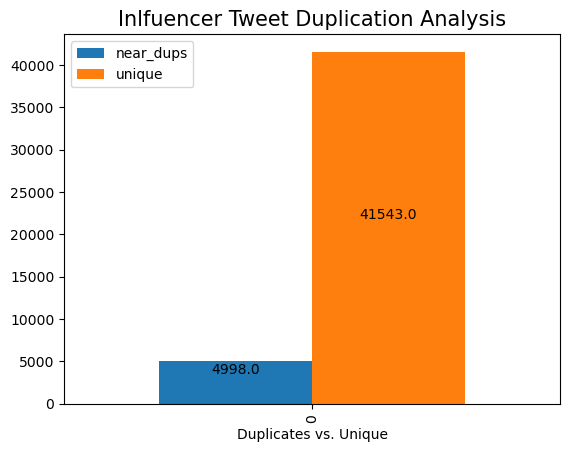

In [ ]:
dups_df = pd.DataFrame.from_dict({'near_dups': [dups], 'unique': [uniques]})

ax=dups_df.plot(kind = 'bar',y=['near_dups', 'unique'], fontsize=10, color=['C0', 'C1'], align='center', width=0.8, xlabel="Duplicates vs. Unique")
ax.set_title('Inlfuencer Tweet Duplication Analysis', fontsize=15)
for p in ax.patches:
       ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()/2), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points') 